In [1]:
import sys
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense, Activation, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
def get_image_lists():
    walk_dir = os.path.join(os.getcwd(), 'pap-smear2005')
    file_list = list(glob.iglob(walk_dir + '**/**/*.BMP', recursive=True))

    normal_cells = []
    abnormal_cells = []

    for filename in file_list:
        if 'normal' in filename:
            normal_cells.append(filename)
        else:
            abnormal_cells.append(filename)

    print("Abnormal cell images count:", len(abnormal_cells))
    print("Normal cell images count:", len(normal_cells))
    return normal_cells, abnormal_cells

def load_image(filename, width=128, height=128):
    image = cv2.imread(filename)
    image = cv2.resize(image, (height, width))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_smear_set():
    normal_file_cells, abnormal_cells = get_image_lists()
    images = []
    labels = []
    for filename in normal_file_cells:
        images.append(load_image(filename))
        labels.append(0)

    for filename in abnormal_cells:
        images.append(load_image(filename))
        labels.append(1)

    images = np.array(images)
    labels = np.array(labels).reshape(-1, 1)
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    images, labels = zip(*dataset)
    # onehot_encoder = OneHotEncoder()
    # labels_encoded = onehot_encoder.fit_transform(labels)
    return images, labels, onehot_encoder.categories_

def get_vgg_model():
    VGG16 = keras.applications.VGG16(input_shape=(128,128, 3),
                                     include_top=False,
                                     weights="imagenet"
                                     )
    # VGG16.summary()
    for layer in VGG16.layers:
        layer.trainable = False
    # for layer in VGG16.layers:
    #     print(layer.name, layer.trainable)

    model = keras.models.Sequential()
    model.add(VGG16)

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.summary()
    return model

In [3]:
X_full, y_full, categories = get_smear_set()

Abnormal cell images count: 675
Normal cell images count: 242
Healhy cell images:  242
Unhealhy cell images:  675


In [4]:
X_full = np.asarray(X_full)
X_full = X_full / 255.
y_full = np.asarray(y_full)


In [5]:
ratio = 0.8
i_split = int(np.ceil(ratio*len(X_full)))

In [6]:

X_train_valid, X_test = X_full[:i_split], X_full[i_split:]
y_train_valid, y_test = y_full[:i_split], y_full[i_split:]

# X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)
kfold = KFold(n_splits=10, shuffle=True)


In [7]:
acc_per_fold = []
loss_per_fold = []
histories = []

In [8]:
fold_no = 0
for train, valid in kfold.split(X_train_valid, y_train_valid): 
    model = get_vgg_model()
    model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(X_train_valid[train], y_train_valid[train],
                validation_data=(X_train_valid[valid], y_train_valid[valid]),
                epochs=100,
                batch_size=15,
                verbose=1)
    histories.append(history)
    scores = model.evaluate(X_test, y_test, verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

917 - val_accuracy: 0.8767
Epoch 71/100
45/45 [==============================] - 1s 14ms/step - loss: 0.3468 - accuracy: 0.8654 - val_loss: 0.3231 - val_accuracy: 0.8493
Epoch 72/100
45/45 [==============================] - 1s 14ms/step - loss: 0.3231 - accuracy: 0.8744 - val_loss: 0.2948 - val_accuracy: 0.8767
Epoch 73/100
45/45 [==============================] - 1s 15ms/step - loss: 0.3324 - accuracy: 0.8623 - val_loss: 0.2880 - val_accuracy: 0.8767
Epoch 74/100
45/45 [==============================] - 1s 15ms/step - loss: 0.3026 - accuracy: 0.8729 - val_loss: 0.2948 - val_accuracy: 0.8767
Epoch 75/100
45/45 [==============================] - 1s 14ms/step - loss: 0.3149 - accuracy: 0.8699 - val_loss: 0.2981 - val_accuracy: 0.8767
Epoch 76/100
45/45 [==============================] - 1s 14ms/step - loss: 0.3145 - accuracy: 0.8684 - val_loss: 0.2833 - val_accuracy: 0.8904
Epoch 77/100
45/45 [==============================] - 1s 14ms/step - loss: 0.3086 - accuracy: 0.8654 - val_loss: 0.

In [9]:
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.22490502893924713 - Accuracy: 91.80327653884888%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.252299964427948 - Accuracy: 90.71038365364075%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.2194325029850006 - Accuracy: 91.80327653884888%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.24873115122318268 - Accuracy: 90.16393423080444%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.2538464367389679 - Accuracy: 90.16393423080444%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.23209327459335327 - Accuracy: 90.71038365364075%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.24737106263637543 - Accuracy: 90.71038365364075%
--

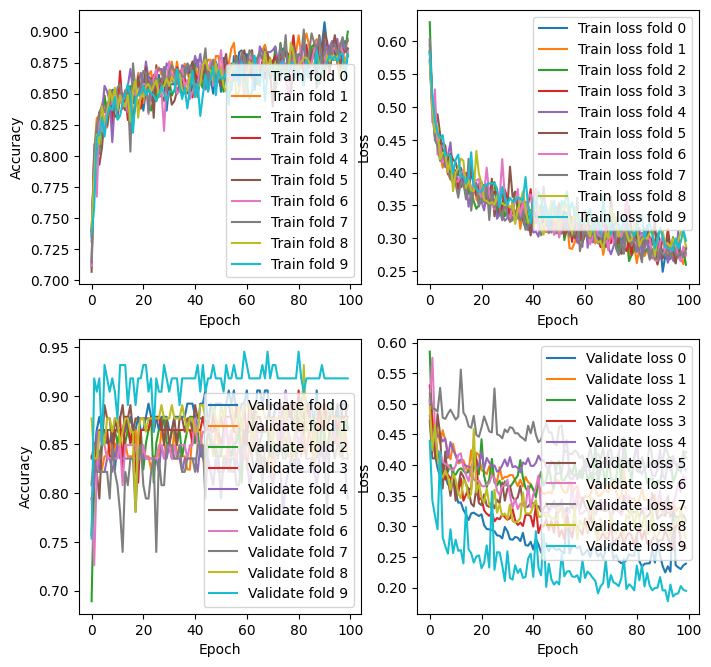

In [19]:
plt.figure(figsize=(8,8), dpi=100)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
for i, history in enumerate(histories):
    
    ax1.plot(history.history['accuracy'], label=f"Train fold {i}")
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label=f"Train loss fold {i}")
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    ax3.plot(history.history['val_accuracy'], label=f"Validate fold {i}")
    ax3.set_ylabel('Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.legend()

    ax4.plot(history.history['val_loss'], label=f"Validate loss {i}")
    ax4.set_ylabel('Loss')
    ax4.set_xlabel('Epoch')
    ax4.legend()

plt.show()
